### Business Scenario

RestoreMasters is a car restoration company based in New York, USA. Within short span of time, this company has become renowned for restoring vintage cars. Their team takes great pride in each of their projects, no matter how big or small. They offer paint jobs, frame build-ups, engine restoration, body work etc. They restore cars of various origins including USA, Europe and Asia. 

The management wants to expand their business by increasing the capacity of the number of cars that can be restored. They want to generate greater revenue for the company through cost cutting and providing a data driven approach to their current process. They feel that the insights from existing data will help them in making data-driven decisions and also automate some of the key tasks in the process. We will be building a Random Forest model that can help in predicting the mileage of incoming cars. 


<hr style="border:2px solid gray">

#**STEP: 0/4** - Run the following lines of code and move to Step 1. 

### Data Cleaning

In [3]:
    %%capture
    !pip install category_encoders==2.*

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
#Update the DATA_PATH variable

import sys

if 'google.colab' in sys.modules:
  # If you're on Colab:
  DATA_PATH = 'https://raw.githubusercontent.com/bloominstituteoftechnology/ds_code_along_unit_2/main/data/restoremasters/'
else:
  # If you're working locally:
  DATA_PATH = '..../data/'

In [6]:
# importing the dataset to Pandas DataFrame: cars_df
cars_df=pd.read_csv(DATA_PATH +'auto_mpg.csv')

In [7]:
# display the data in DataFrame: cars_df
cars_df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


In [ ]:
# Check the number of rows and number of columns in Pandas DataFrame: cars_df
cars_df.shape

(398, 9)

In [ ]:
# check the row index labels of Pandas DataFrame: cars_df
cars_df.index

RangeIndex(start=0, stop=398, step=1)

In [ ]:
# Get the concise summary of DataFrame: cars_df
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    object 
 8   name          398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [ ]:
# Get the statistical summary of numeric columns of DataFrame: cars_df
cars_df.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000


<hr style="border:2px solid gray">


#**STEP: 1/4** - Handle missing values and high cardinality columns

In [ ]:
# finding missing values 
cars_df.isna().any()

mpg             False
cylinders       False
displacement    False
horsepower       True
weight          False
acceleration    False
model_year      False
origin          False
name            False
dtype: bool

In [ ]:
# find the number of missing values 
cars_df.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
name            0
dtype: int64

In [ ]:
# find the rows where missing values are present
cars_df[cars_df['horsepower'].isna()]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
32,25.0,4,98.0,NaN,2046,19.0,71,usa,ford pinto
126,21.0,6,200.0,NaN,2875,17.0,74,usa,ford maverick
330,40.9,4,85.0,NaN,1835,17.3,80,europe,renault lecar deluxe
336,23.6,4,140.0,NaN,2905,14.3,80,usa,ford mustang cobra
354,34.5,4,100.0,NaN,2320,15.8,81,europe,renault 18i
374,23.0,4,151.0,NaN,3035,20.5,82,usa,amc concord dl


In [8]:
# Replacing missing values with mean horsepower of cars with similar cylinders and model_year
cars_df['horsepower'] = cars_df.groupby(['cylinders', 'model_year'])['horsepower'].apply(lambda x: x.fillna(x.mean()))

In [9]:
# checking for missing values in columns of the DataFrame: cars_df
cars_df.isna().any()

mpg             False
cylinders       False
displacement    False
horsepower      False
weight          False
acceleration    False
model_year      False
origin          False
name            False
dtype: bool

In [10]:
# drop high cardinality columns
cars_df.drop(columns='name',inplace=True)

<hr style="border:2px solid gray">

#**STEP: 2/4** - Handle duplicate values and check for column types

In [ ]:
# find the number of duplicate records the DataFrame: cars_df
cars_df.duplicated().sum()

0

In [ ]:
# get the duplicate records in the DataFrame: cars_df
cars_df[cars_df.duplicated()]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin


In [ ]:
# dropping the duplicate records in the DataFrame: cars_df
cars_df.drop_duplicates(inplace=True)
cars_df.duplicated().sum()

0

In [ ]:
# get the data types of all columns of the DataFrame: cars_df
cars_df.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight            int64
acceleration    float64
model_year        int64
origin           object
dtype: object

In [ ]:
# setting data type of origin as 'category'
cars_df['origin']=cars_df['origin'].astype('category')
cars_df['origin'].dtype

CategoricalDtype(categories=['europe', 'japan', 'usa'], ordered=False)

<hr style="border:2px solid gray">

#**STEP: 3/4** - Handle outliers

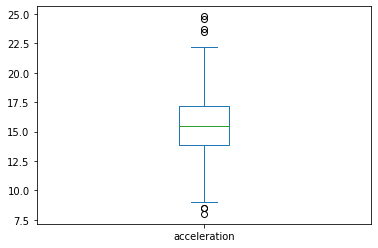

In [11]:
# A boxplot gives a good indication of distribution of data about the median. 

cars_df['acceleration'].plot(kind='box')
plt.show()

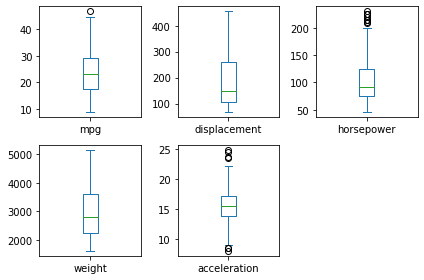

In [ ]:
# box-plot for all numerical columns of the DataFrame: cars_df
# plt.subplot(norows, ncols, plot_number)
# Plotting subplots On a grid of 2 rows x 3 columns

# box plot for mpg
plt.subplot(2,3,1)
cars_df['mpg'].plot(kind='box') 

# box plot for displacement
plt.subplot(2,3,2) 
cars_df['displacement'].plot(kind='box') 

# box plot for horsepower
plt.subplot(2,3,3) 
cars_df['horsepower'].plot(kind='box') 

# box plot for weight
plt.subplot(2,3,4) 
cars_df['weight'].plot(kind='box') 

# box plot for acceleration
plt.subplot(2,3,5) 
cars_df['acceleration'].plot(kind='box') 

plt.tight_layout()
plt.show()

In [ ]:
cars_df[['mpg','displacement','horsepower','weight','acceleration']].describe()

,mpg,displacement,horsepower,weight,acceleration
count,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,193.425879,104.099083,2970.424623,15.568090
std,7.815984,104.269838,38.336173,846.841774,2.757689
min,9.000000,68.000000,46.000000,1613.000000,8.000000
25%,17.500000,104.250000,75.000000,2223.750000,13.825000
50%,23.000000,148.500000,92.000000,2803.500000,15.500000
75%,29.000000,262.000000,125.000000,3608.000000,17.175000
max,46.600000,455.000000,230.000000,5140.000000,24.800000


In [12]:
# finding the upper and lower limit of horespower and acceleration columns

def find_outlier_limits(col_name):
    Q1,Q3=cars_df[col_name].quantile([.25,.75])
    IQR=Q3-Q1
    low=Q1-(1.5* IQR)
    high=Q3+(1.5* IQR)
    return (high,low)

high_hp,low_hp=find_outlier_limits('horsepower')
print('Horsepower: ','upper limit: ',high_hp,' lower limit: ',low_hp)
high_acc,low_acc=find_outlier_limits('acceleration')
print('Acceleration: ','upper limit: ',high_acc,' lower limit:',low_acc)


Horsepower:  upper limit:  200.0  lower limit:  0.0
Acceleration:  upper limit:  22.2  lower limit: 8.8


In [13]:
# Replacing outlier values in horespower and acceleration columns with respective 
# upper and lower limits

cars_df.loc[cars_df['horsepower']>high_hp,'horsepower']=high_hp
cars_df.loc[cars_df['acceleration']>high_acc,'acceleration']=high_acc
cars_df.loc[cars_df['acceleration']<low_acc,'acceleration']=low_acc

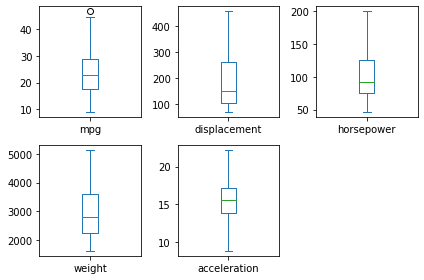

In [14]:
# box-plot for all numerical columns of the DataFrame: cars_df
# plt.subplot(norows, ncols, plot_number)
# Plotting subplots On a grid of 2 rows x 3 columns

# box plot for mpg
plt.subplot(2,3,1)
cars_df['mpg'].plot(kind='box') 

# box plot for displacement
plt.subplot(2,3,2) 
cars_df['displacement'].plot(kind='box') 

# box plot for horsepower
plt.subplot(2,3,3) 
cars_df['horsepower'].plot(kind='box') 

# box plot for horsepower
plt.subplot(2,3,4) 
cars_df['weight'].plot(kind='box') 

# box plot for acceleration
plt.subplot(2,3,5) 
cars_df['acceleration'].plot(kind='box') 

plt.tight_layout()

<hr style="border:2px solid gray">

#**STEP: 4/4** - Encode categorical columns and build a Random Forest Model

In [15]:
# Split the data into Feature Matrix and Target Vector

target = 'mpg'
y = cars_df[target]
X = cars_df.drop(columns=[target])

In [16]:
# Split data into Train and Test Sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [17]:
#Determine the baseline MAE

y_pred_baseline = [y_train.mean()] * len(y_train)
print('BASELINE MAE', mean_absolute_error(y_train,y_pred_baseline))

BASELINE MAE 6.684739527708555


In [18]:
# Random Forest Regressor

model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestRegressor(random_state=42,n_jobs=-1)
);

model.fit(X_train,y_train);

In [19]:
# mapping of class to label used for encoding

model.named_steps['ordinalencoder'].category_mapping

[{'col': 'origin', 'data_type': dtype('O'), 'mapping': usa       1
  japan     2
  europe    3
  NaN      -2
  dtype: int64}]

In [21]:
# check your metrics
print('Test MAE:', mean_absolute_error(y_test, model.predict(X_test)))

Test MAE: 1.6458249999999992


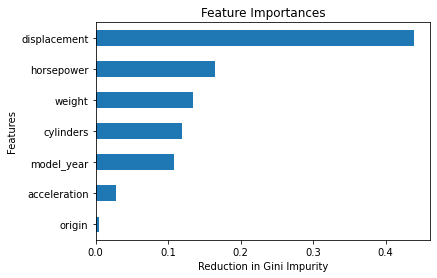

In [22]:
# Plot the top ten feature importances

importances = model.named_steps['randomforestregressor'].feature_importances_
features = model.named_steps['ordinalencoder'].get_feature_names()
feat_imp = pd.Series(importances, index=features).sort_values(key=abs)
feat_imp.tail(20).plot(kind='barh')
plt.xlabel('Reduction in Gini Impurity')
plt.ylabel('Features')
plt.title('Feature Importances');